In [41]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
import ipywidgets as widgets


FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

FILTERED_COUNTIES = ['Unknown'] # Exclude data where county name is not listed

%config InlineBackend.figure_format = 'retina'

In [23]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

In [25]:
url_counties = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties_full = pd.read_csv(url_counties,
                     usecols=[0,1,2,4],
                     index_col=['county', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

In [26]:
state_list = sorted(set(counties_full.state.unique()) - set(FILTERED_REGIONS))
len(state_list) # Include District of Columbia

51

In [27]:
selected_state = 'New York'

In [29]:
counties = counties_full[counties_full.state==selected_state]
counties = counties.drop(columns=['state'], axis=1)
counties = counties.squeeze()
counties

county  date      
Albany  2020-03-12     2
        2020-03-13     2
        2020-03-14     5
        2020-03-15    11
        2020-03-16    12
                      ..
Yates   2020-04-17     8
        2020-04-18     9
        2020-04-19     9
        2020-04-20    10
        2020-04-21    10
Name: cases, Length: 2072, dtype: int64

In [31]:
county_list = counties.reset_index().county.unique()
county_list

array(['Albany', 'Allegany', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
       'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
       'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery', 'Nassau',
       'New York City', 'Niagara', 'Oneida', 'Onondaga', 'Ontario',
       'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Rensselaer',
       'Rockland', 'Saratoga', 'Schenectady', 'Schoharie', 'Schuyler',
       'Seneca', 'St. Lawrence', 'Steuben', 'Suffolk', 'Sullivan',
       'Tioga', 'Tompkins', 'Ulster', 'Unknown', 'Warren', 'Washington',
       'Wayne', 'Westchester', 'Wyoming', 'Yates'], dtype=object)

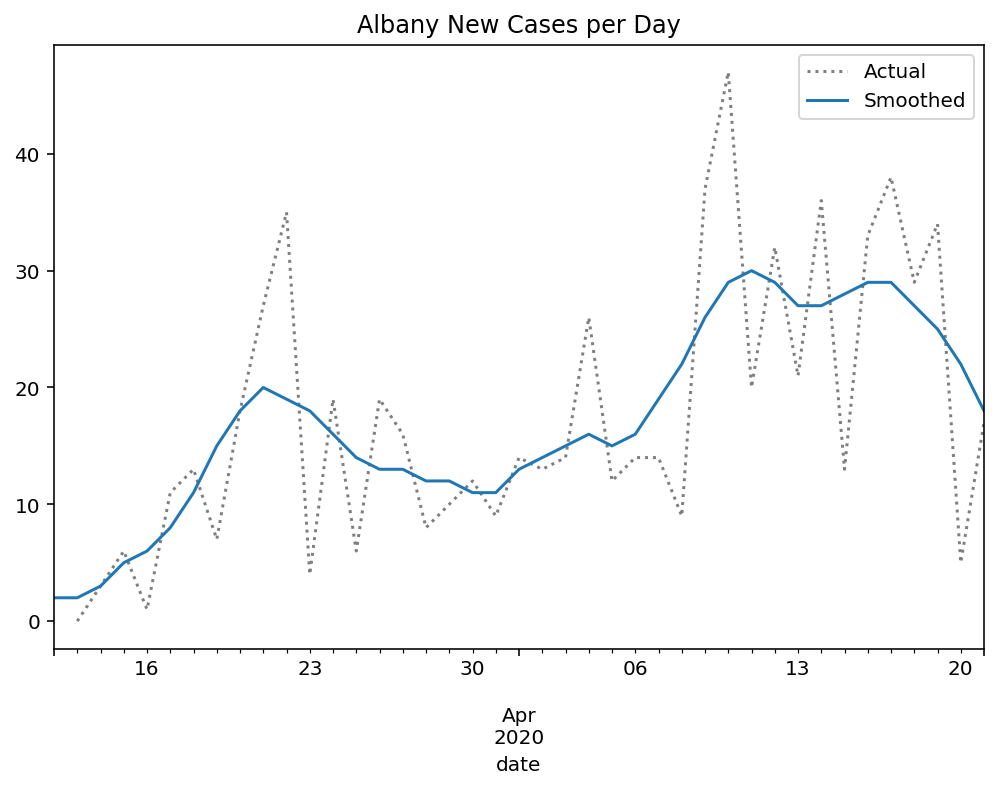

In [13]:
county_name = county_list[0] # Albany

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = counties.xs(county_name).rename(f"{county_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{county_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Running the Algorithm

In [32]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

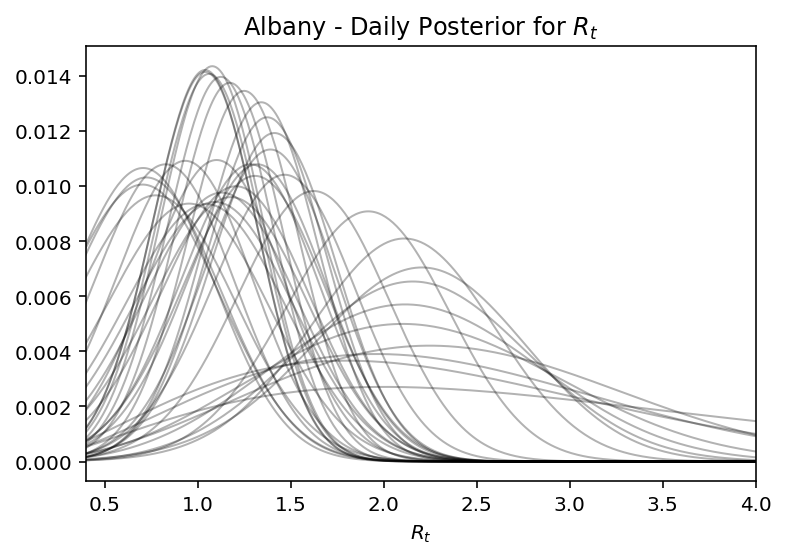

In [47]:
ax = posteriors.plot(title=f'{county_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [48]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-04-15,1.12,0.57,1.70
2020-04-16,1.06,0.51,1.63
2020-04-17,1.04,0.49,1.60
2020-04-18,1.04,0.50,1.61
2020-04-19,1.08,0.54,1.64


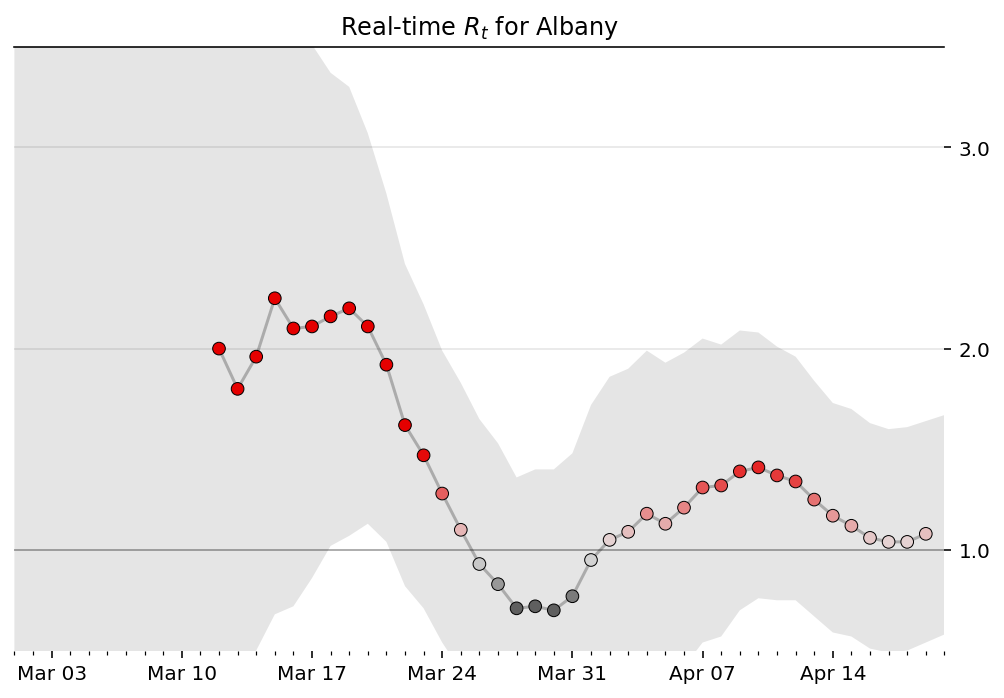

In [49]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, county_name)
ax.set_title(f'Real-time $R_t$ for {county_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the Process for Every County

In [46]:
states = list(counties_full['state'].unique())
states.remove('Puerto Rico')
states.remove('Virgin Islands')
states.remove('Guam')
states.remove('Northern Mariana Islands')
len(states)

51

In [63]:
states

['South Carolina',
 'Louisiana',
 'Virginia',
 'Idaho',
 'Iowa',
 'Missouri',
 'Oklahoma',
 'Kentucky',
 'Indiana',
 'Colorado',
 'Nebraska',
 'Pennsylvania',
 'Illinois',
 'Mississippi',
 'Washington',
 'Wisconsin',
 'Ohio',
 'Vermont',
 'Minnesota',
 'Florida',
 'North Carolina',
 'California',
 'New York',
 'Wyoming',
 'Michigan',
 'Maryland',
 'Alaska',
 'Tennessee',
 'Texas',
 'Kansas',
 'Maine',
 'Arizona',
 'Georgia',
 'Arkansas',
 'New Jersey',
 'South Dakota',
 'Alabama',
 'West Virginia',
 'North Dakota',
 'Massachusetts',
 'Montana',
 'New Hampshire',
 'Oregon',
 'New Mexico',
 'Utah',
 'Rhode Island',
 'Nevada',
 'District of Columbia',
 'Connecticut',
 'Hawaii',
 'Delaware']

In [66]:
states = sorted(states)

In [96]:
import time

In [133]:
master = {}
t0 = time.time()
for st in states:
    results = {}
    counties = counties_full[counties_full.state==st]
    counties = counties.drop(columns=['state'], axis=1)
    counties = counties.squeeze()

    counties_to_process = counties.loc[~counties.index.get_level_values('county').isin(['Unknown'])]

    for county_name, cases in counties_to_process.groupby(level='county'):
        clear_output(wait=True)
        print(f'Processing {county_name}')
        new, smoothed = prepare_cases(cases)
        print('\tGetting Posteriors')
        try:
            posteriors = get_posteriors(smoothed)
        except:
            display(cases)
        print('\tGetting HDIs')
        hdis = highest_density_interval(posteriors)
        print('\tGetting most likely values')
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis], axis=1)
        results[county_name] = result.droplevel(0)
    clear_output(wait=True)
    print('Done.')
    master[st] = results
t1 = time.time()

Done.


In [134]:
master.keys()

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [135]:
len(master.keys())

51

In [143]:
t1 - t0 

10000.707383155823

In [5]:
print(10000.707383155823 /3600,'hours')

2.7779742730988395 hours


### Export Data to CSV

In [137]:
frames = []
for state in master:
    for county in master[state]:
        c = pd.DataFrame(master[state][county])
        c['state'] = state
        c['county'] = county
        frames.append(c)
out = pd.concat(frames)
out

,ML,Low,High,state,county
date,,,,,
2020-04-07,2.00,0.34,6.43,Alabama,Autauga
2020-04-08,1.88,0.38,5.01,Alabama,Autauga
2020-04-09,1.80,0.38,4.45,Alabama,Autauga
2020-04-10,1.74,0.40,4.13,Alabama,Autauga
2020-04-11,1.69,0.37,3.85,Alabama,Autauga
...,...,...,...,...,...
2020-04-17,1.00,0.00,2.69,Wyoming,Washakie
2020-04-18,1.00,0.00,2.69,Wyoming,Washakie
2020-04-19,1.00,0.00,2.69,Wyoming,Washakie


In [138]:
out.to_csv("full_output.csv")